# 0. Load Files

In [2]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA

import joblib

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_parquet("/Users/bennyschellinger/Desktop/DataScience/MLE_DataScientest/04_Projekt/new_github_repo/MAY24_BDS_INT_Fire_Brigade/data/df_cleaned_for_classification_models.parquet")
df.head() 

IncidentGroup_Fire  IncidentGroup_Special Service  \
IncidentNumber                                                      
235138081                        0                              1   
2091                             1                              0   
3091                             1                              0   
5091                             1                              0   
6091                             0                              0   

                AggregatedPropertyCategory_Outdoor  \
IncidentNumber                                       
235138081                                        0   
2091                                             1   
3091                                             1   
5091                                             1   
6091                                             0   

                AggregatedPropertyCategory_Residential  \
IncidentNumber                                           
235138081                                            0   
2091                                                 0   
3091                                                 0   
5091                                                 0   
6091                                                 1   

                AggregatedPropertyCategory_Vehicle  \
IncidentNumber                                       
235138081                                        1   
2091                                             0   
3091                                             0   
5091                                             0   
6091                                             0   

                CellEastingNorthing2500_502500-175000  \
IncidentNumber                                          
235138081                                           0   
2091                                                0   
3091                                                0   
5091                                                0   
6091                                                0   

                CellEastingNorthing2500_502500-177500  \
IncidentNumber                                          
235138081                                           0   
2091                                                0   
3091                                                0   
5091                                                0   
6091                                                0   

                CellEastingNorthing2500_502500-180000  \
IncidentNumber                                          
235138081                                           0   
2091                                                0   
3091                                                0   
5091                                                0   
6091                                                0   

                CellEastingNorthing2500_502500-182500  \
IncidentNumber                                          
235138081                                           0   
2091                                                0   
3091                                                0   
5091                                                0   
6091                                                0   

                CellEastingNorthing2500_502500-187500  \
IncidentNumber                                          
235138081                                           0   
2091                                                0   
3091                                                0   
5091                                                0   
6091                                                0   

                CellEastingNorthing2500_502500-190000  \
IncidentNumber                                          
235138081                                           0   
2091                                                0   
3091                                                0   
5091                                                0   
6091                     

# 1. Training Voting Classifier (Hard)

In [4]:
X = df.drop("ResponseTimeBinary", axis = 1)
y = df["ResponseTimeBinary"]

In [5]:
pca = PCA(n_components=0.85)
X_pca = pca.fit_transform(X)

In [6]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size = 0.2, random_state = 666)


In [7]:
rUs = RandomUnderSampler(random_state=666)
X_ru, y_ru = rUs.fit_resample(X_train_pca, y_train_pca)
print('Sample classes undersampled :', dict(pd.Series(y_ru).value_counts()))


Sample classes undersampled : {0: 361454, 1: 361454}


In [8]:
xgboost = xgb.XGBClassifier(random_state=666)
rf = RandomForestClassifier(random_state=666)
logreg = LogisticRegression(random_state=666)

In [9]:
params_xgboost = {
    'XGboost__learning_rate': [0.1],
    'XGboost__max_depth': [5],
    'XGboost__n_estimators': [200],
    'XGboost__subsample': [0.9]
}
params_rf = {
    'RF__criterion': ['gini'],
    'RF__max_depth': [10],
    'RF__n_estimators': [200]
}
params_logreg = {
    'LogReg__C': [5],
    'LogReg__penalty': ['l2'],
    'LogReg__solver': ['lbfgs']
}

# Combine parameters into a single dictionary
params = {**params_xgboost, **params_rf, **params_logreg}

In [10]:
vclf_hard = VotingClassifier(estimators=[('XGboost', xgboost), ('RF', rf), ('LogReg', logreg)], voting='hard')

In [11]:
vclf_hard_grid = GridSearchCV(estimator=vclf_hard, param_grid=params, cv=5)
vclf_hard_grid.fit(X_ru, y_ru)

GridSearchCV(cv=5,
             estimator=VotingClassifier(estimators=[('XGboost',
                                                     XGBClassifier(base_score=None,
                                                                   booster=None,
                                                                   callbacks=None,
                                                                   colsample_bylevel=None,
                                                                   colsample_bynode=None,
                                                                   colsample_bytree=None,
                                                                   device=None,
                                                                   early_stopping_rounds=None,
                                                                   enable_categorical=False,
                                                                   eval_metric=None,
                                                                   feature_types=None,
                                                                   gamma=None,
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interact...
                                                     RandomForestClassifier(random_state=666)),
                                                    ('LogReg',
                                                     LogisticRegression(random_state=666))]),
             param_grid={'LogReg__C': [5], 'LogReg__penalty': ['l2'],
                         'LogReg__solver': ['lbfgs'], 'RF__criterion': ['gini'],
                         'RF__max_depth': [10], 'RF__n_estimators': [200],
                         'XGboost__learning_rate': [0.1],
                         'XGboost__max_depth': [5],
                         'XGboost__n_estimators': [200],
                         'XGboost__subsample': [0.9]})

In [20]:
best_voting_clf_hard = vclf_hard_grid.best_estimator_
best_voting_clf_hard

VotingClassifier(estimators=[('XGboost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learnin...
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=666, ...)),
                             ('RF',
                              RandomForestClassifier(max_depth=10,
                                                     n_estimators=200,
                                                     random_state=666)),
                             ('LogReg',
                              LogisticRegression(C=5, random_state=666))])

In [23]:
# Extract fitted models
fitted_xgb = best_voting_clf_hard.named_estimators_['XGboost']
fitted_rf = best_voting_clf_hard.named_estimators_['RF']
fitted_logreg = best_voting_clf_hard.named_estimators_['LogReg']

In [45]:
print(fitted_xgb)
print(fitted_rf)
print(fitted_logreg)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=666, ...)
RandomForestClassifier(max_depth=10, n_estimators=200, random_state=666)
LogisticRegression(C=5, random_state=666)


In [27]:
num_components = X_test_pca.shape[1]
pca_feature_names = [f'PC{i+1}' for i in range(num_components)]

# 2. SHAP Values & Interpretation

## 2.1 SHAP Value Calculation

In [24]:
import shap

def get_shap_values(model, X, model_type='tree'):
    if model_type == 'tree':
        explainer = shap.TreeExplainer(model)
    elif model_type == 'linear':
        explainer = shap.LinearExplainer(model, X)
    else:
        explainer = shap.KernelExplainer(model.predict, X)
    shap_values = explainer.shap_values(X)
    return shap_values, explainer

[14:37:22] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


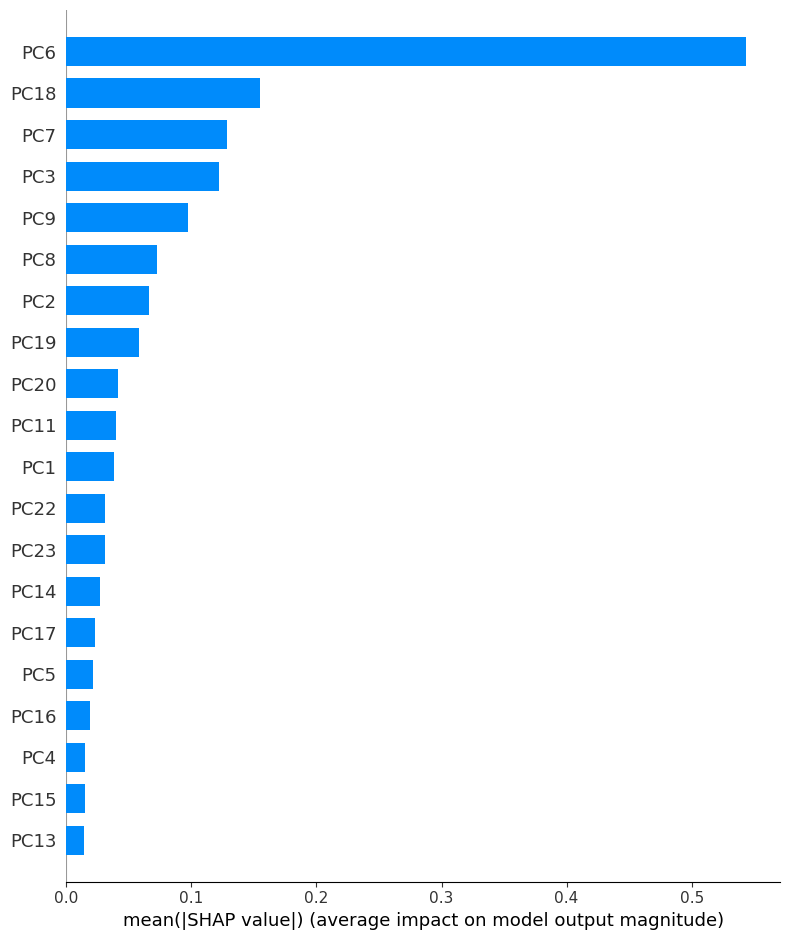

In [28]:
# Get SHAP values for XGBoost
shap_values_xgb, explainer_xgb = get_shap_values(fitted_xgb, X_test_pca, model_type='tree')
shap.summary_plot(shap_values_xgb, X_test_pca, feature_names=pca_feature_names, plot_type="bar")

In [67]:
shap_values_xgb_class1 = shap_values_xgb
shap_values_xgb_class0 = -shap_values_xgb_class1

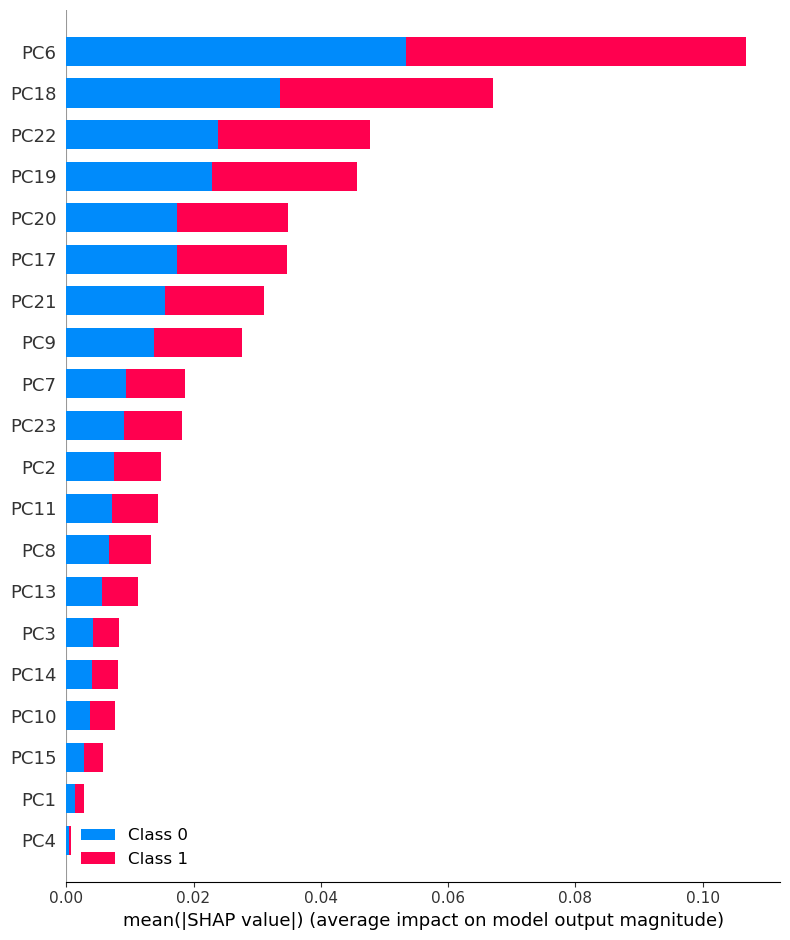

In [29]:
# Get SHAP values for RandomForest
shap_values_rf, explainer_rf = get_shap_values(fitted_rf, X_test_pca, model_type='tree')
shap.summary_plot(shap_values_rf, X_test_pca, feature_names=pca_feature_names, plot_type="bar")

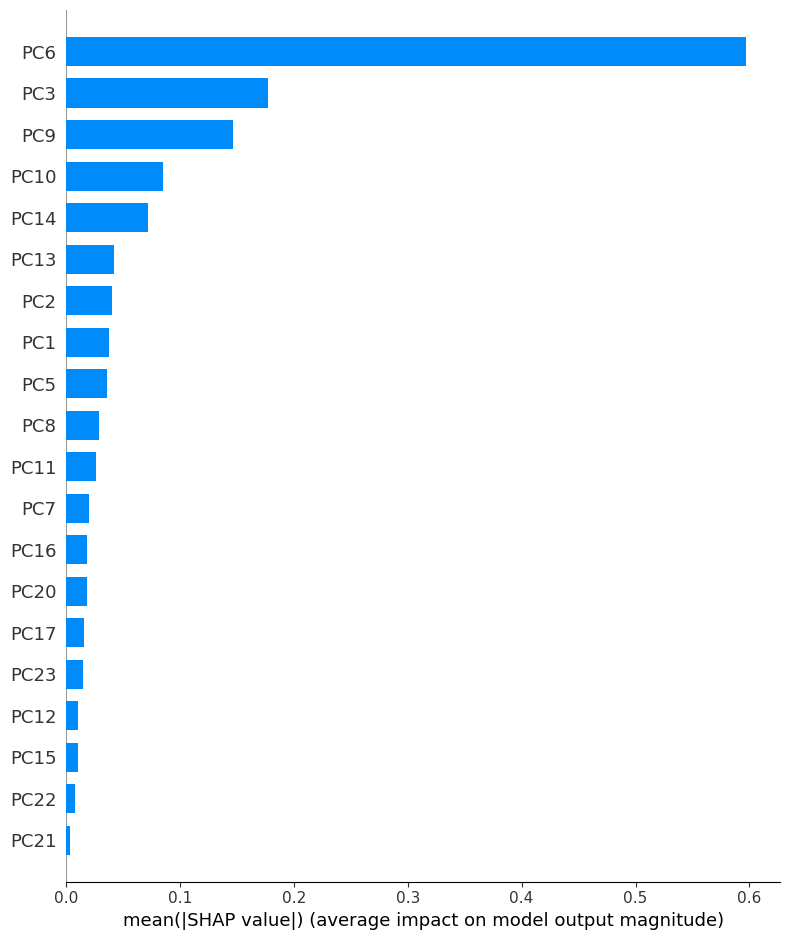

In [46]:
# Get SHAP values for Logistic Regression
shap_values_logreg, explainer_logreg = get_shap_values(fitted_logreg, X_test_pca, model_type='linear')
shap.summary_plot(shap_values_logreg, X_test_pca, feature_names=pca_feature_names, plot_type="bar")

In [70]:
shap_values_logreg_class1 = shap_values_logreg
shap_values_logreg_class0 = -shap_values_logreg_class1

In [71]:
print("SHAP Values XGBoost (class 1, first 5 samples):", shap_values_xgb_class1[:5])
print("SHAP Values XGBoost (class 0, first 5 samples):", shap_values_xgb_class0[:5])
print("SHAP Values RandomForest (class 0, first 5 samples):", shap_values_rf[0][:5])
print("SHAP Values RandomForest (class 1, first 5 samples):", shap_values_rf[1][:5])
print("SHAP Values Logistic Regression (class 1, first 5 samples):", shap_values_logreg_class1[:5])
print("SHAP Values Logistic Regression (class 0, first 5 samples):", shap_values_logreg_class0[:5])

SHAP Values XGBoost (class 1, first 5 samples): [[-1.12643577e-02  3.94982472e-03  1.29324317e-01  2.69010812e-02
   2.37117149e-02 -9.40131903e-01 -4.62861098e-02  5.54631241e-02
  -1.32181734e-01 -2.71909544e-03 -6.13037869e-03 -1.83977548e-03
  -4.84794937e-02  3.07075121e-02  2.29075085e-02 -2.90159173e-02
   5.89943677e-02 -1.60289079e-01  1.17768131e-01  1.32158905e-01
   2.97083743e-02  9.48915258e-02  6.95636198e-02]
 [-5.96080385e-02  1.11853875e-01 -9.97936446e-03  5.56891877e-03
   2.17412319e-02  8.81945908e-01  1.97485819e-01 -1.44103821e-03
   2.12268680e-01  2.58430815e-03  2.82826573e-02  1.69770103e-02
   1.09338267e-02  1.38690844e-02 -1.30595863e-02  3.44274659e-03
  -3.86617100e-03 -1.51289284e-01  1.43541172e-02  2.07832634e-01
   2.94354539e-02  4.04181937e-03 -1.63276047e-02]
 [-4.29291166e-02 -3.89788449e-02  7.97063410e-02  5.89507306e-03
  -2.43030712e-02 -1.01554252e-01  2.78279409e-02  9.31424573e-02
   1.07052373e-02  5.00655174e-03 -1.86287351e-02  1.21819

## 2.2 SHAP Visualization

### Analyze SHAP Values Individually

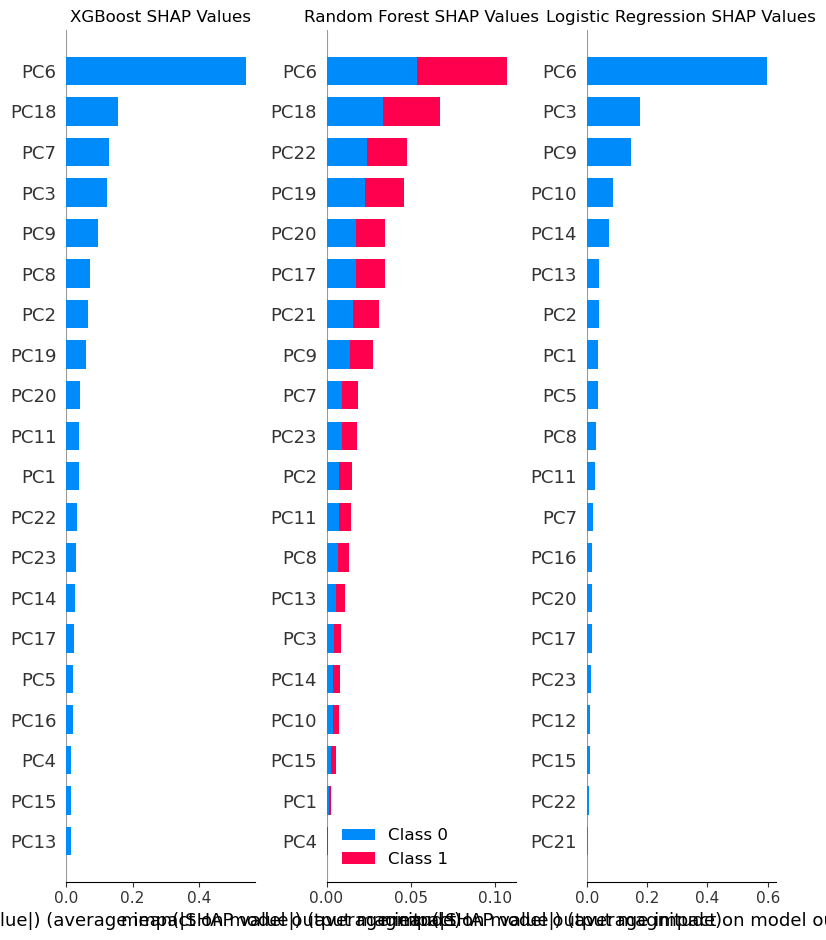

In [113]:
import matplotlib.pyplot as plt

# Generate SHAP summary plots separately and save them
plt.figure(figsize=(18, 6))

# XGBoost SHAP summary plot
plt.subplot(1, 3, 1)
shap.summary_plot(shap_values_xgb, X_test_pca, feature_names=pca_feature_names, plot_type="bar", show=False)
plt.title('XGBoost SHAP Values')

# RandomForest SHAP summary plot
plt.subplot(1, 3, 2)
shap.summary_plot(shap_values_rf, X_test_pca, feature_names=pca_feature_names, plot_type="bar", show=False)
plt.title('Random Forest SHAP Values')

# LogisticRegression SHAP summary plot
plt.subplot(1, 3, 3)
shap.summary_plot(shap_values_logreg, X_test_pca, feature_names=pca_feature_names, plot_type="bar", show=False)
plt.title('Logistic Regression SHAP Values')

# Adjust layout and show
plt.tight_layout()
plt.savefig("/Users/bennyschellinger/Desktop/DataScience/MLE_DataScientest/04_Projekt/new_github_repo/MAY24_BDS_INT_Fire_Brigade/img/shap_model_comparison.png")
plt.show()


### Compare SHAP Values Across Models

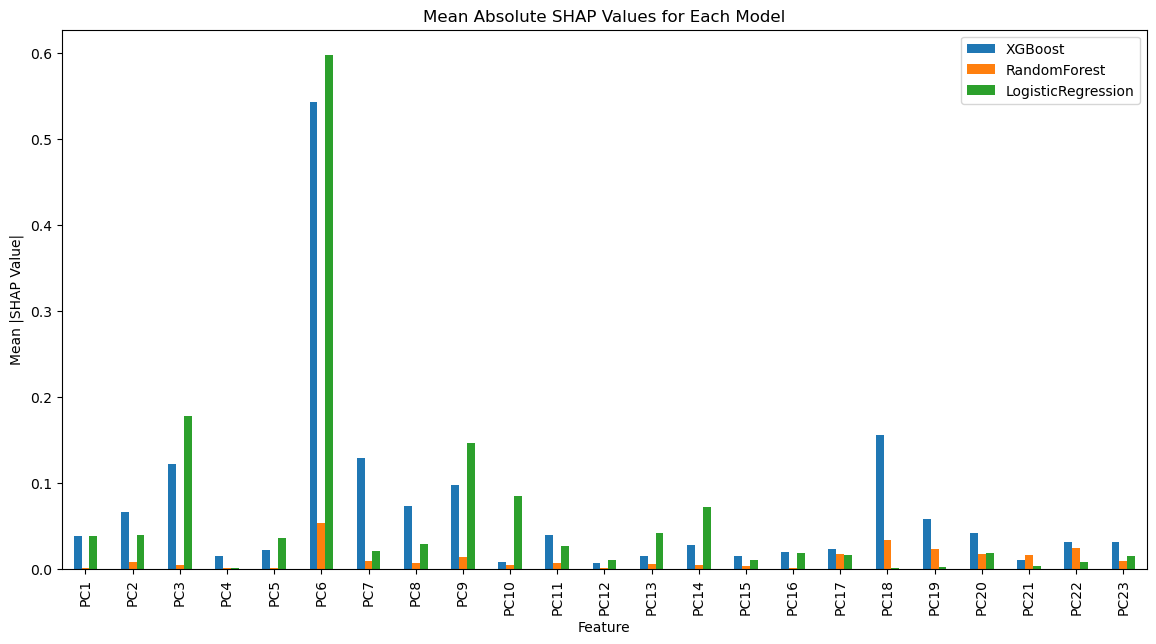

In [114]:
# Assuming the shap_values_* are numpy arrays, compute mean absolute SHAP values for each feature
import numpy as np

mean_abs_shap_xgb = np.abs(shap_values_xgb).mean(axis=0)
mean_abs_shap_rf = np.abs(shap_values_rf[1]).mean(axis=0)  # Using the SHAP values for class 1
mean_abs_shap_logreg = np.abs(shap_values_logreg).mean(axis=0)

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Feature': pca_feature_names,
    'XGBoost': mean_abs_shap_xgb,
    'RandomForest': mean_abs_shap_rf,
    'LogisticRegression': mean_abs_shap_logreg
})

# Plot comparison
comparison_df.set_index('Feature').plot(kind='bar', figsize=(14, 7))
plt.title('Mean Absolute SHAP Values for Each Model')
plt.ylabel('Mean |SHAP Value|')
plt.savefig("/Users/bennyschellinger/Desktop/DataScience/MLE_DataScientest/04_Projekt/new_github_repo/MAY24_BDS_INT_Fire_Brigade/img/mean_abs_shap_comparison.png")
plt.show()

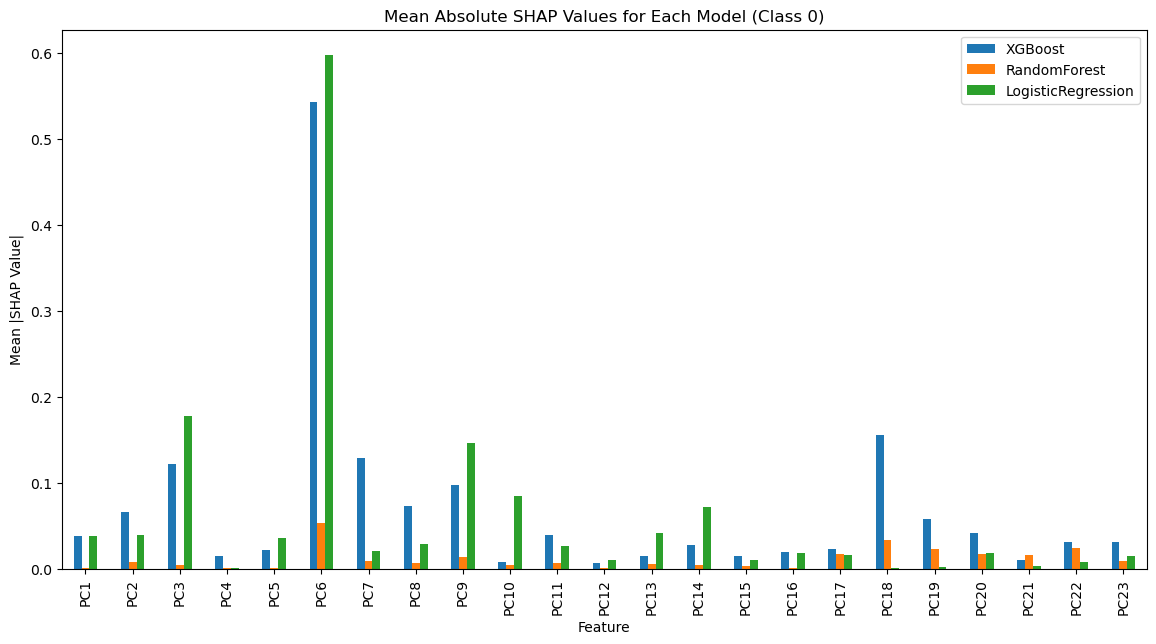

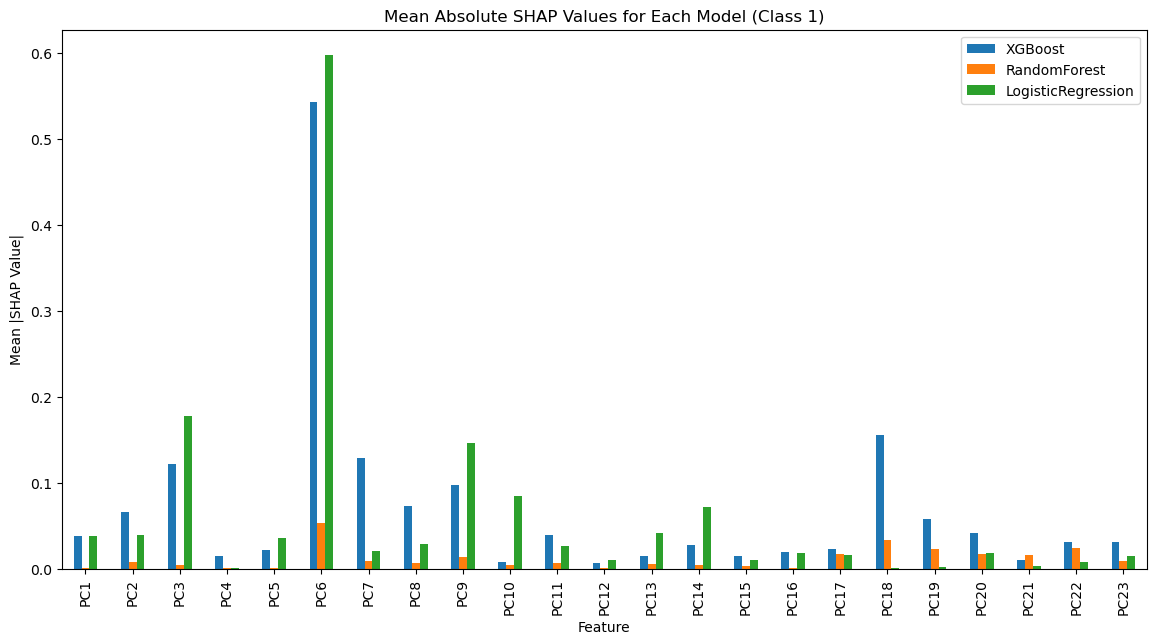

In [112]:
# Compute mean absolute SHAP values for class 0 and class 1
mean_abs_shap_xgb_class0 = np.abs(shap_values_xgb_class0).mean(axis=0)
mean_abs_shap_xgb_class1 = np.abs(shap_values_xgb_class1).mean(axis=0)
mean_abs_shap_rf_class0 = np.abs(shap_values_rf[0]).mean(axis=0)
mean_abs_shap_rf_class1 = np.abs(shap_values_rf[1]).mean(axis=0)
mean_abs_shap_logreg_class0 = np.abs(shap_values_logreg_class0).mean(axis=0)
mean_abs_shap_logreg_class1 = np.abs(shap_values_logreg_class1).mean(axis=0)

# Create DataFrames for comparison
comparison_df_class0 = pd.DataFrame({
    'Feature': pca_feature_names,
    'XGBoost': mean_abs_shap_xgb_class0,
    'RandomForest': mean_abs_shap_rf_class0,
    'LogisticRegression': mean_abs_shap_logreg_class0
})

comparison_df_class1 = pd.DataFrame({
    'Feature': pca_feature_names,
    'XGBoost': mean_abs_shap_xgb_class1,
    'RandomForest': mean_abs_shap_rf_class1,
    'LogisticRegression': mean_abs_shap_logreg_class1
})

# Set the feature names as the index for the DataFrames
comparison_df_class0.set_index('Feature', inplace=True)
comparison_df_class1.set_index('Feature', inplace=True)

# Plot comparison for class 0
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
comparison_df_class0.plot(kind='bar', ax=ax)
ax.set_title('Mean Absolute SHAP Values for Each Model (Class 0)')
ax.set_ylabel('Mean |SHAP Value|')
plt.show()

# Plot comparison for class 1
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
comparison_df_class1.plot(kind='bar', ax=ax)
ax.set_title('Mean Absolute SHAP Values for Each Model (Class 1)')
ax.set_ylabel('Mean |SHAP Value|')
plt.show()


### SHAP Violin Plots for for Each Model in the Voting Classifier

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


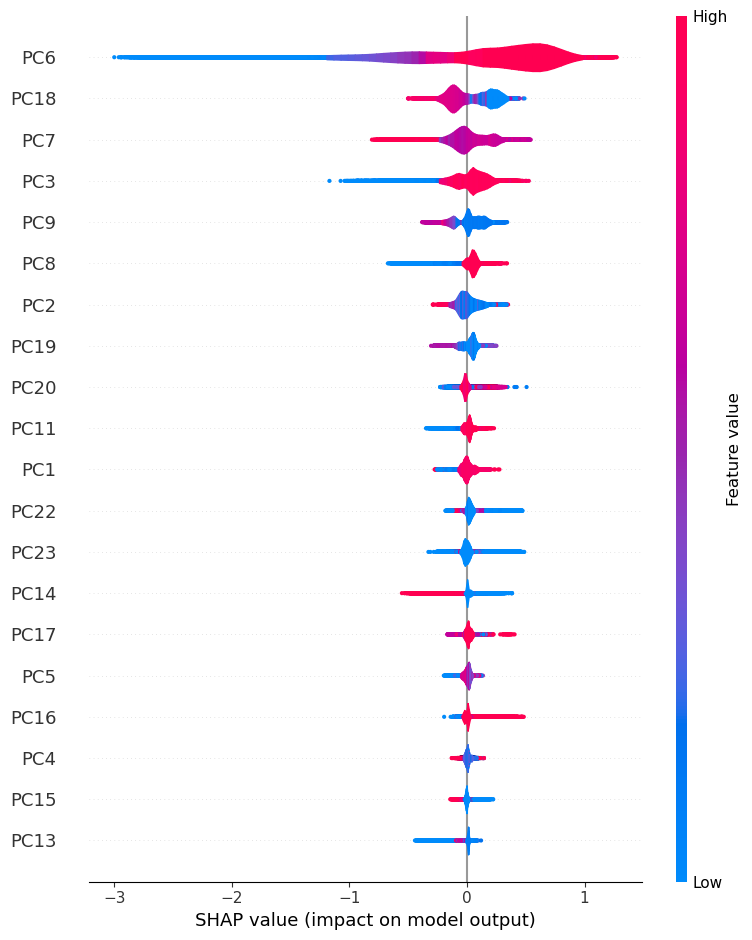

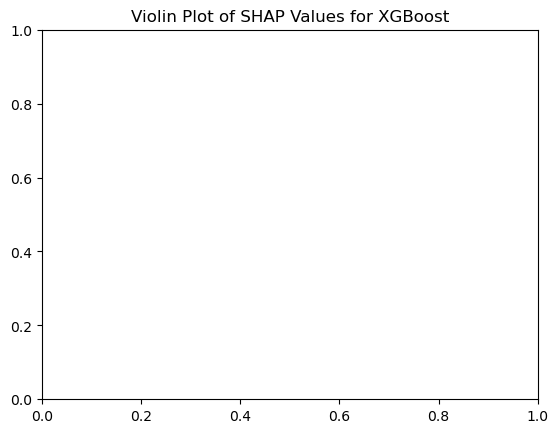

In [115]:
plt.figure()
shap.summary_plot(shap_values_xgb, X_test_pca, feature_names=pca_feature_names, plot_type="violin")
plt.title('Violin Plot of SHAP Values for XGBoost')
plt.show()


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


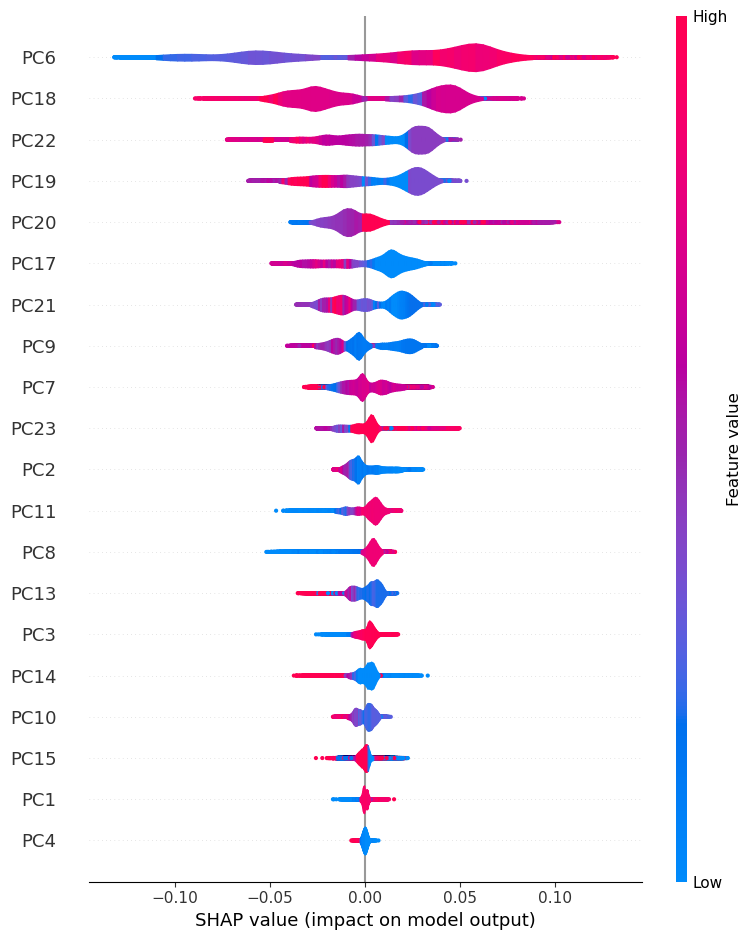

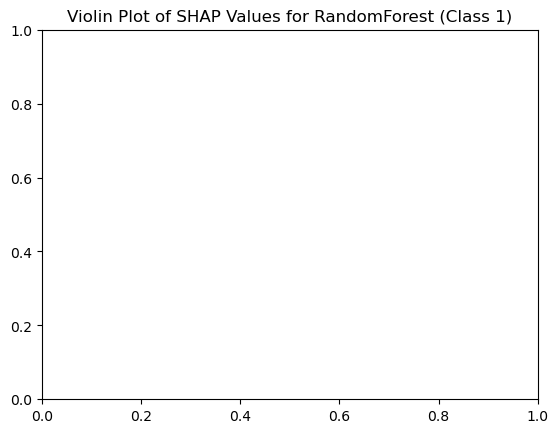

In [116]:
plt.figure()
shap.summary_plot(shap_values_rf[1], X_test_pca, feature_names=pca_feature_names, plot_type="violin")
plt.title('Violin Plot of SHAP Values for RandomForest (Class 1)')
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


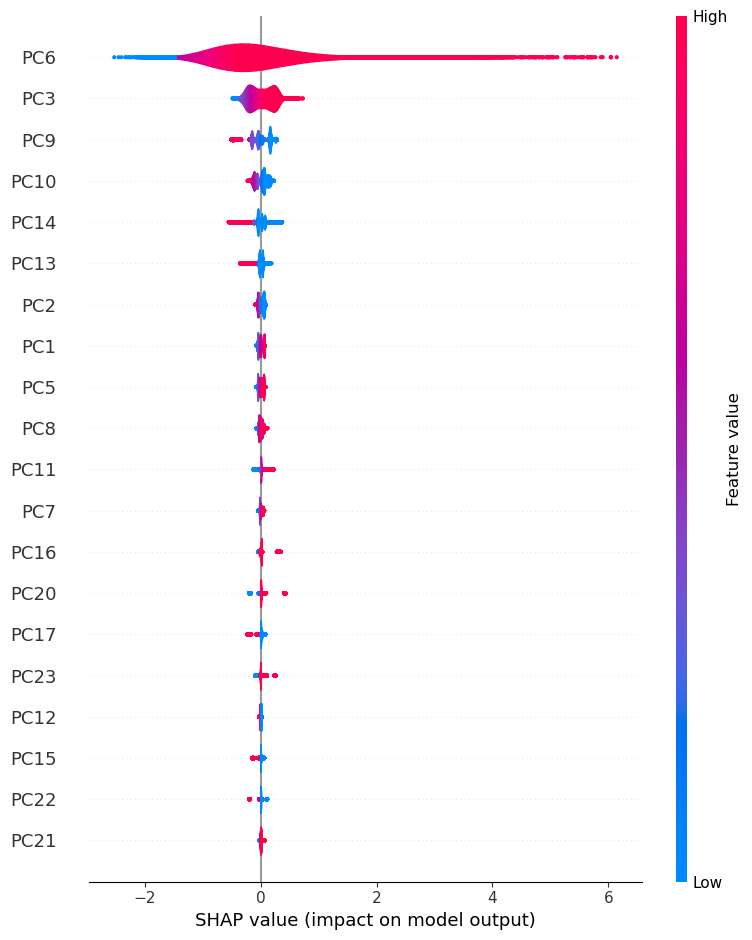

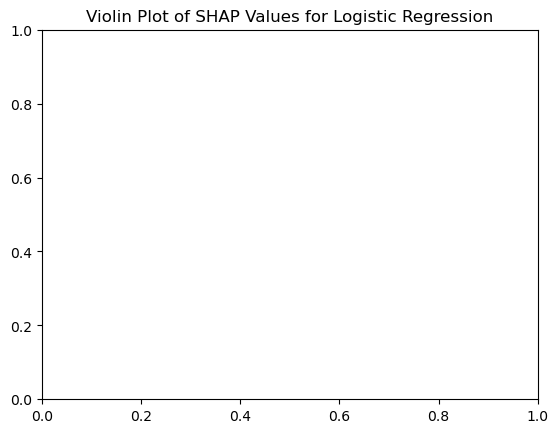

In [117]:
plt.figure()
shap.summary_plot(shap_values_logreg, X_test_pca, feature_names=pca_feature_names, plot_type="violin")
plt.title('Violin Plot of SHAP Values for Logistic Regression')
plt.show()

### Average SHAP Violin Plot for Voting Classifier

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


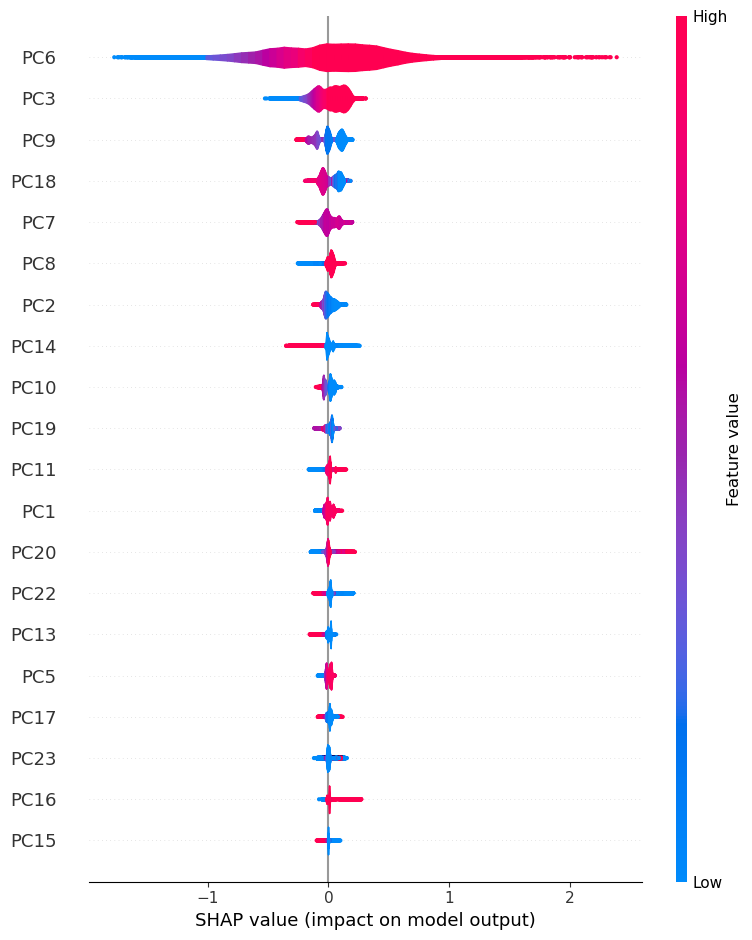

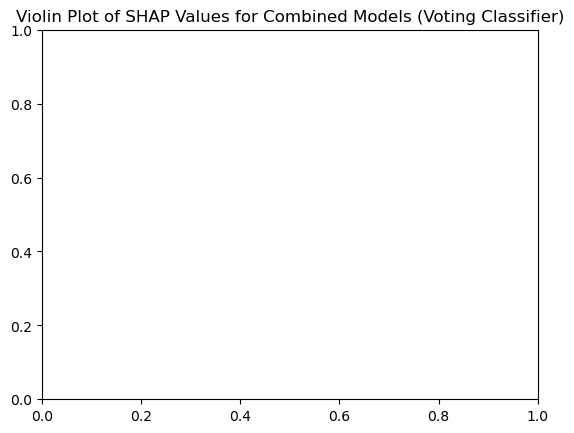

In [75]:
# Compute the average SHAP values across models
shap_values_combined = (shap_values_xgb + shap_values_rf[1] + shap_values_logreg) / 3

# Plot combined violin plot
plt.figure()
shap.summary_plot(shap_values_combined, X_test_pca, feature_names=pca_feature_names, plot_type="violin")
plt.title('Violin Plot of SHAP Values for Combined Models (Voting Classifier)')
plt.show()


### Local Interpretation for one Observation

SHAP allows you to display, at the local level, a graph showing the reasoning that led the model to classify an individual in such a class, in relation to the values of the most influential variables. Variables increasing the probability of earning more money are in red, those decreasing the probability are in blue.

In [124]:
def format_shap_values(shap_values, decimals=3):
    return np.round(shap_values, decimals)

# Format SHAP values for each model
shap_values_xgb_formatted = format_shap_values(shap_values_xgb, decimals=3)
shap_values_rf_formatted_class1 = format_shap_values(shap_values_rf[1], decimals=3)
shap_values_logreg_formatted = format_shap_values(shap_values_logreg, decimals=3)


In [126]:
shap.initjs()
shap.force_plot(explainer_xgb.expected_value, shap_values_xgb_formatted[3, :], X_test_pca[3, :], feature_names=pca_feature_names)

In [128]:
shap.force_plot(explainer_rf.expected_value[1], shap_values_rf_formatted_class1[3, :], X_test_pca[3, :], feature_names=pca_feature_names)


In [129]:
shap.force_plot(explainer_logreg.expected_value, shap_values_logreg_formatted[3, :], X_test_pca[3, :], feature_names=pca_feature_names)


### Combined Force Plot for Voting Classifier

In [130]:
# Compute the average SHAP values across models
shap_values_combined = (shap_values_xgb + shap_values_rf[1] + shap_values_logreg) / 3
shap_values_combined_formatted = format_shap_values(shap_values_combined, decimals=3)

In [133]:
shap.initjs()

# Use the base value from the XGBoost explainer for simplicity.
# This value represents the model's expected output.
shap.force_plot(explainer_xgb.expected_value, shap_values_combined_formatted[3, :], X_test_pca[3, :], feature_names=pca_feature_names)

### Interactive Plot for first 1000 Observations

One of the main advantages of SHAP is that it allows the construction of interactive global graphs that can visualize and explain several predictions at once. Here we visualize the model prediction decisions for the first 1000 samples of test data.

In [107]:
shap.force_plot(explainer_xgb.expected_value, shap_values_xgb[:1000], X_test_pca[:1000])

In [108]:
shap.force_plot(explainer_rf.expected_value[1], shap_values_rf[1][:1000], X_test_pca[:1000])

In [104]:
shap.force_plot(explainer_logreg.expected_value, shap_values_logreg[:1000], X_test_pca[:1000])

### Voting Classifier

In [ ]:
shap.force_plot(explainer_xgb.expected_value, shap_values_combined_formatted[:5000], X_test_pca[:5000])